# CellNet

In [1]:
IMAGES = 'all'; AUGS = 'val'
P = 'sigma'; ps = [1, 3, 5, 7, 9, 11, 13]


import ast
from math import prod
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch

import albumentations as A
from albumentations.pytorch import ToTensorV2

from types import SimpleNamespace as obj

import util.data as data
import util.plot as plot


CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if CUDA else 'cpu'); print('device =', device)
DRAFT = False if os.getenv('BATCHED_RUN', '0')=='1' else True; print('DRAFT =', DRAFT)

def gpu(x, device=device): return torch.from_numpy(x).float().to(device)
def cpu(x): return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x

key2text = {'tl': 'Training Loss',     'vl': 'Validation Loss', 
            'ta': 'Training Accuracy', 'va': 'Validation Accuracy', 
            'ti': 'Training Image',    'vi': 'Validation Image',
            'lf': 'Loss Function',     'lr': 'Learning Rate',
            'e' : 'Epoch',             'bs': 'Batch Size',
            'fraction': 'Fraction of Data',  'sparsity': 'Artificial Sparsity',  
            'sigma': 'Gaussian Sigma',        'maxdist': 'Max Distance',
            }

CROPSIZE=256

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


device = cuda:0
DRAFT = False


In [2]:
XNorm = data.mk_XNorm([1,2,4])

def mkAugs(mode):
  T = lambda ts:  A.Compose(transforms=[
    A.PadIfNeeded(CROPSIZE, CROPSIZE, border_mode=0, value=0),
    *ts,
    XNorm(), 
    A.PadIfNeeded(CROPSIZE, CROPSIZE, border_mode=0, value=0),
    ToTensorV2(transpose_mask=True, always_apply=True)], 
    keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True) # type: ignore
  )

  vals = [A.D4(),
          ]

  return dict(
    test  = T([]),
    val   = T([A.RandomCrop(CROPSIZE, CROPSIZE, p=1),
               *vals]),
    train = T([
               A.RandomCrop(CROPSIZE, CROPSIZE, p=1),
              #A.RandomSizedCrop(p=1, min_max_height=(CROPSIZE//2, CROPSIZE*2), height=CROPSIZE, width=CROPSIZE),
              # NOTE: issue with resize is that the keypoint sizes will not be updated
               A.Rotate(),
               A.AdvancedBlur(),
               A.Equalize(),
               A.ColorJitter(), 
               A.GaussNoise(),
               *vals])
  )[mode]

In [3]:
def plot_overlay(B, cfg, ax=None):
  ax = plot.image(B.x, ax=ax)
  plot.heatmap(1-B.m, ax=ax, alpha=lambda x: 0.5*x, color='#000000')
  plot.heatmap(  B.z, ax=ax, alpha=lambda x: 1.0*x, color='#ff0000')
  plot.points(ax, B.k, 6, B.l)
  return ax

def plot_diff(B, cfg, ax=None):
  title = f"Difference between Target and Predicted Heatmap"
  D = B.y-B.z; D[0, 1,0] = -1; D[0, 1,1] = 1 
  ax = plot.image(D, ax=ax, cmap='coolwarm')
  plot.heatmap(1-B.m, ax=ax, alpha=lambda x: 0.2*x, color='#000000')
  plot.points(ax, B.k, 6, B.l)
  return ax

batch2cpu = lambda B, z=None, y=None: [obj(**{k:cpu(v) for v,k in zip(b, 'xmklzy')}) 
              for b in zip(B['image'], B['masks'][0], B['keypoints'], B['class_labels'], 
              *([] if z is None else [z]), *([] if y is None else [y]))]

if DRAFT and not CUDA: 
  _cfg = obj(sigma=4, maxdist=26, fraction=1, sparsity=1)
  kp2hm, yunnorm = data.mk_kp2mh_yunnorm([1,2,4], _cfg)

  def plot_grid(grid, **loader_kwargs):
    loader = data.mk_loader([1], cfg=_cfg, bs=prod(grid), **loader_kwargs)
    B = next(iter(loader))
    B = batch2cpu(B, z=kp2hm(B))
    for b,ax in zip(B, plot.grid(grid, [CROPSIZE]*2)[1]):
      plot_overlay(b, _cfg, ax=ax)

  for B in data.mk_loader([1,2,4], cfg=_cfg, bs=1, transforms=mkAugs('test'), shuffle=False):
    ax = plot_overlay(batch2cpu(B, z=kp2hm(B))[0], _cfg)

  plot_grid((3,3), transforms=mkAugs('val'))
  plot_grid((3,3), transforms=mkAugs('train'))

In [4]:
import segmentation_models_pytorch as smp
plt.close('all')

mk_model = lambda: smp.Unet(  # NOTE TODO: check if spefically used model automatically mirror pads in training or inference
    encoder_name="resnet34" if DRAFT else "resnet152",  # 18 34 50 101 152
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation='sigmoid',
  ).to(device)  

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


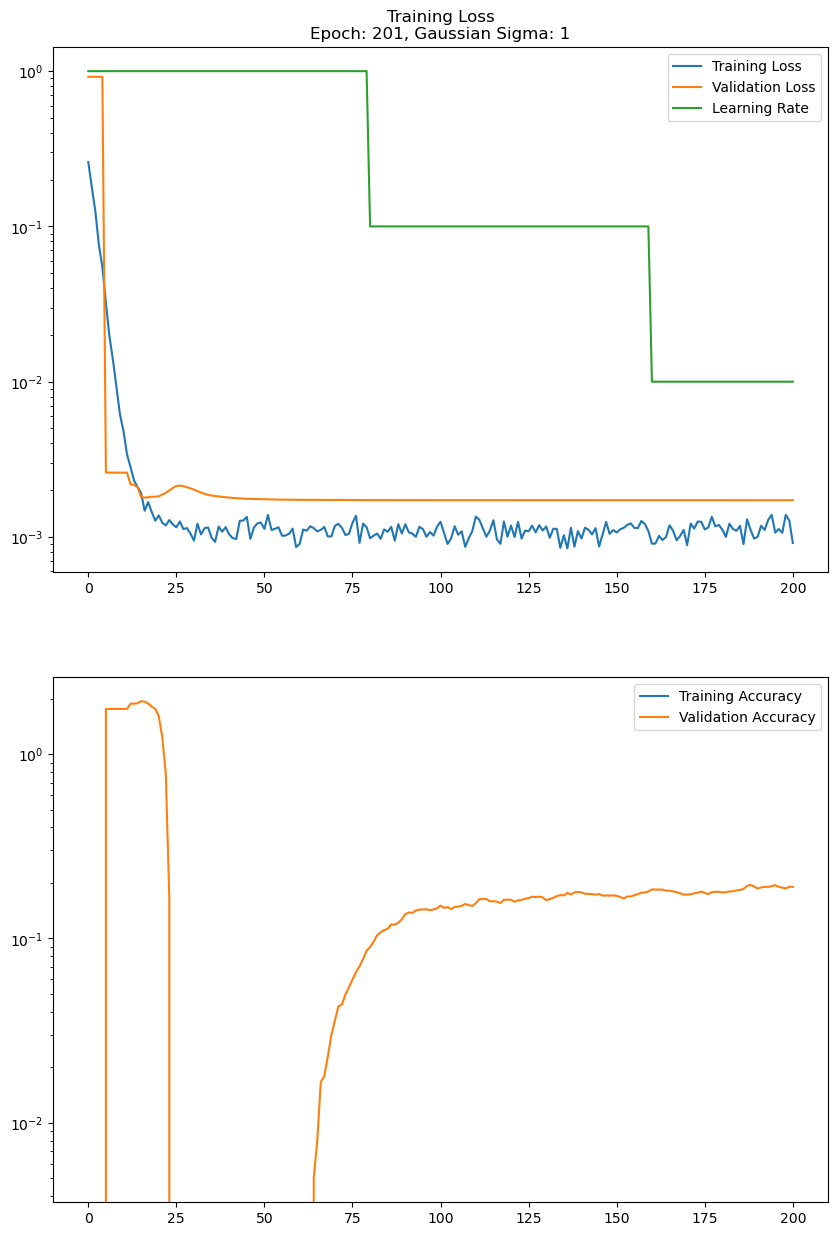

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


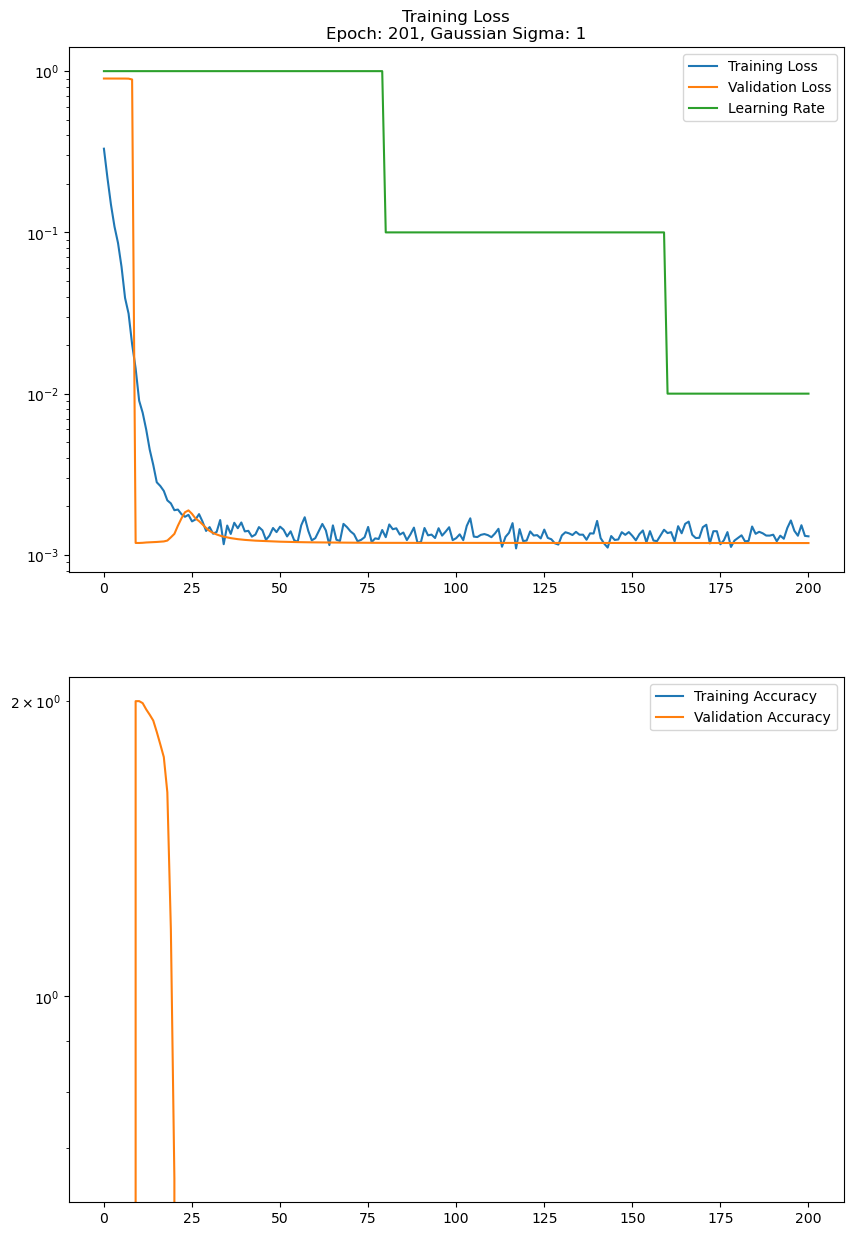

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


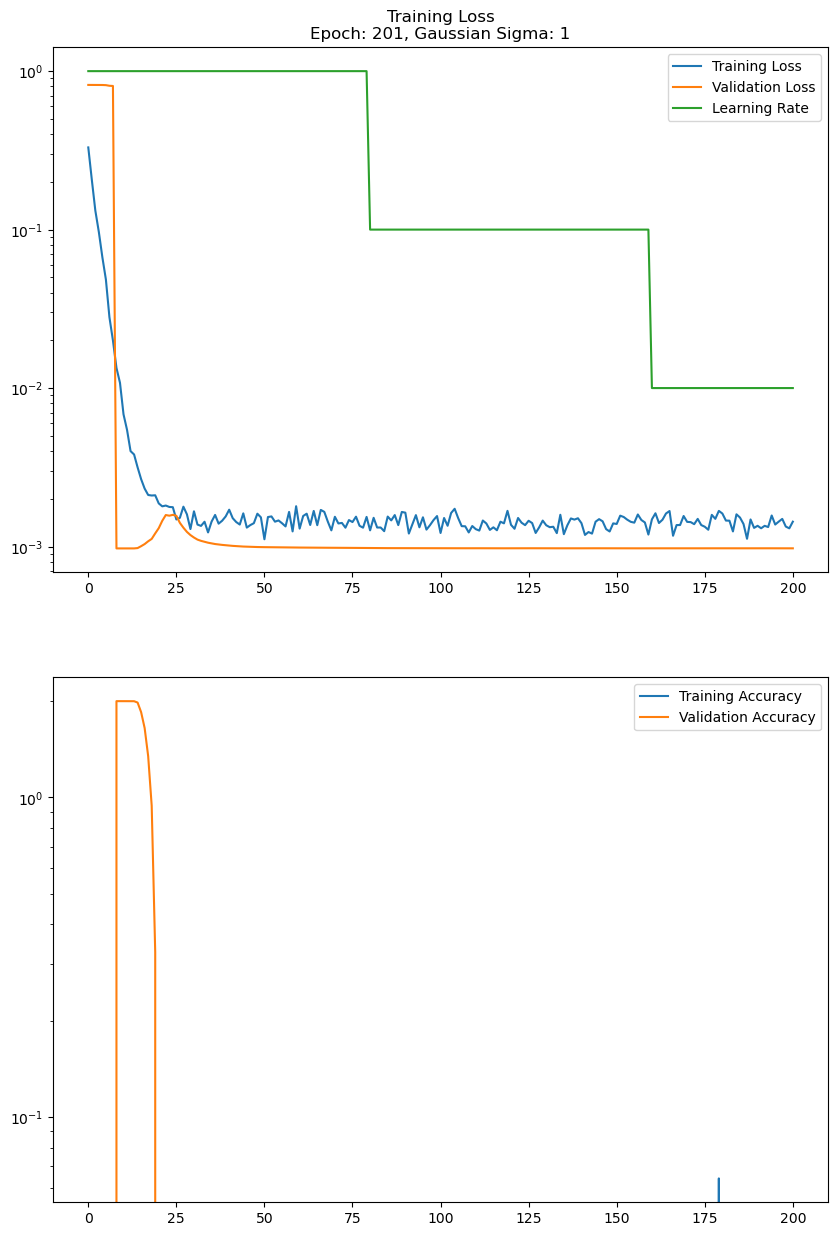

/gpfs/space/home/eckhardt/sanger/results/cellnet/240531-184339-sigma-val-all-RUNNING/util/plot.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


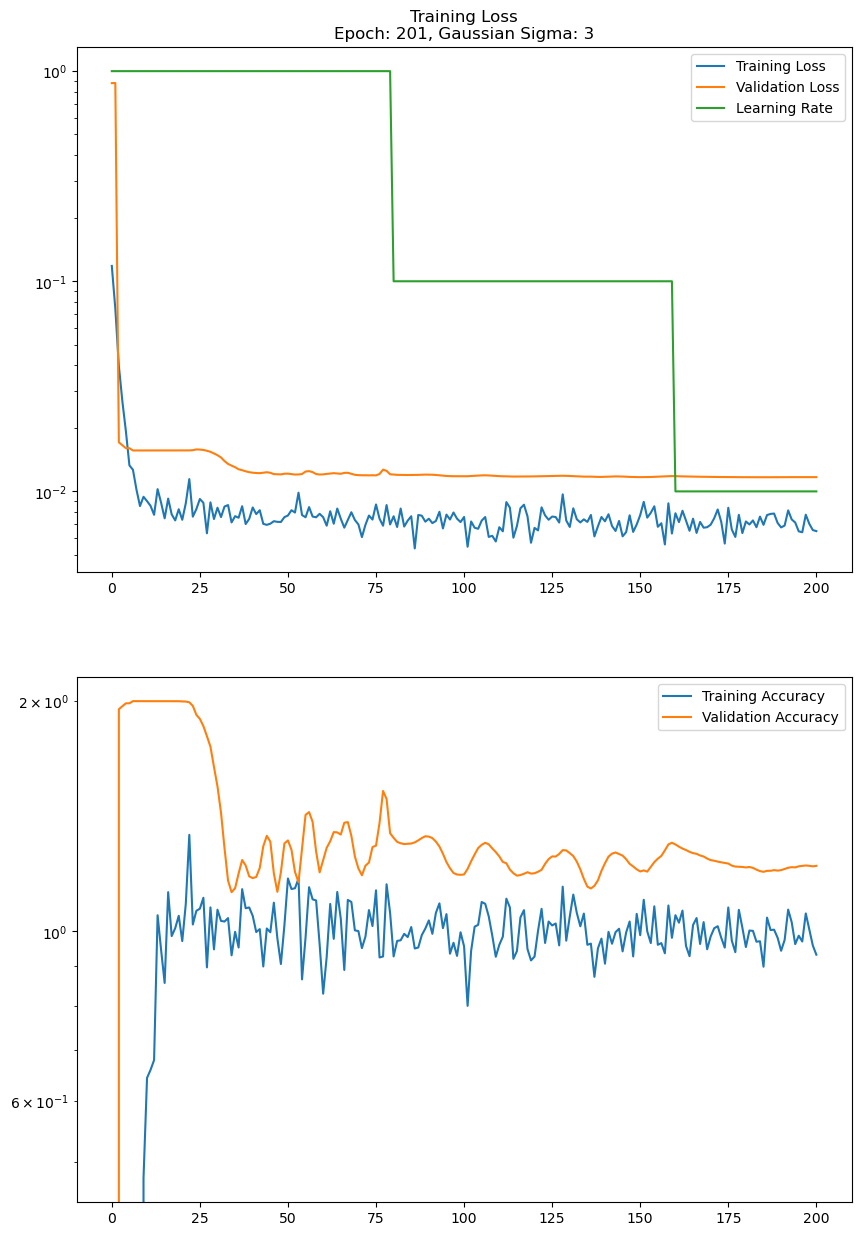

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


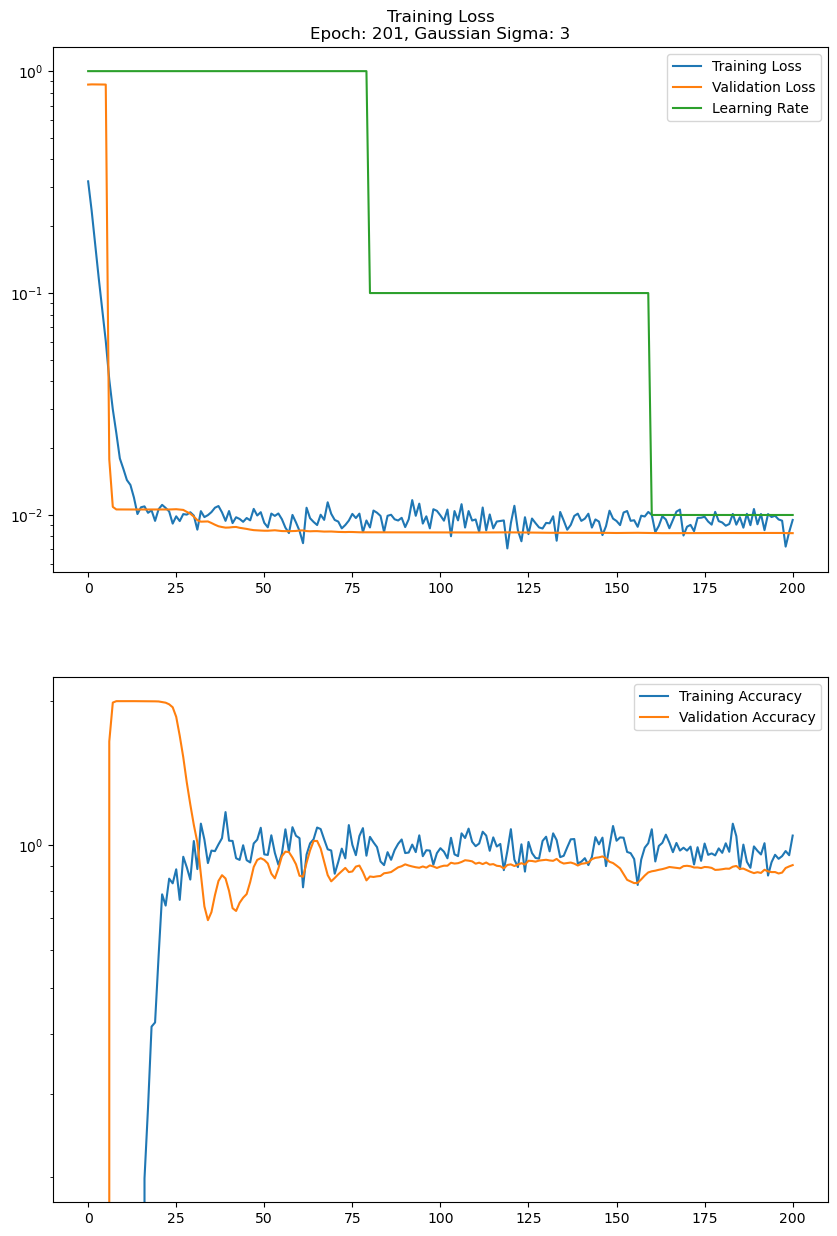

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


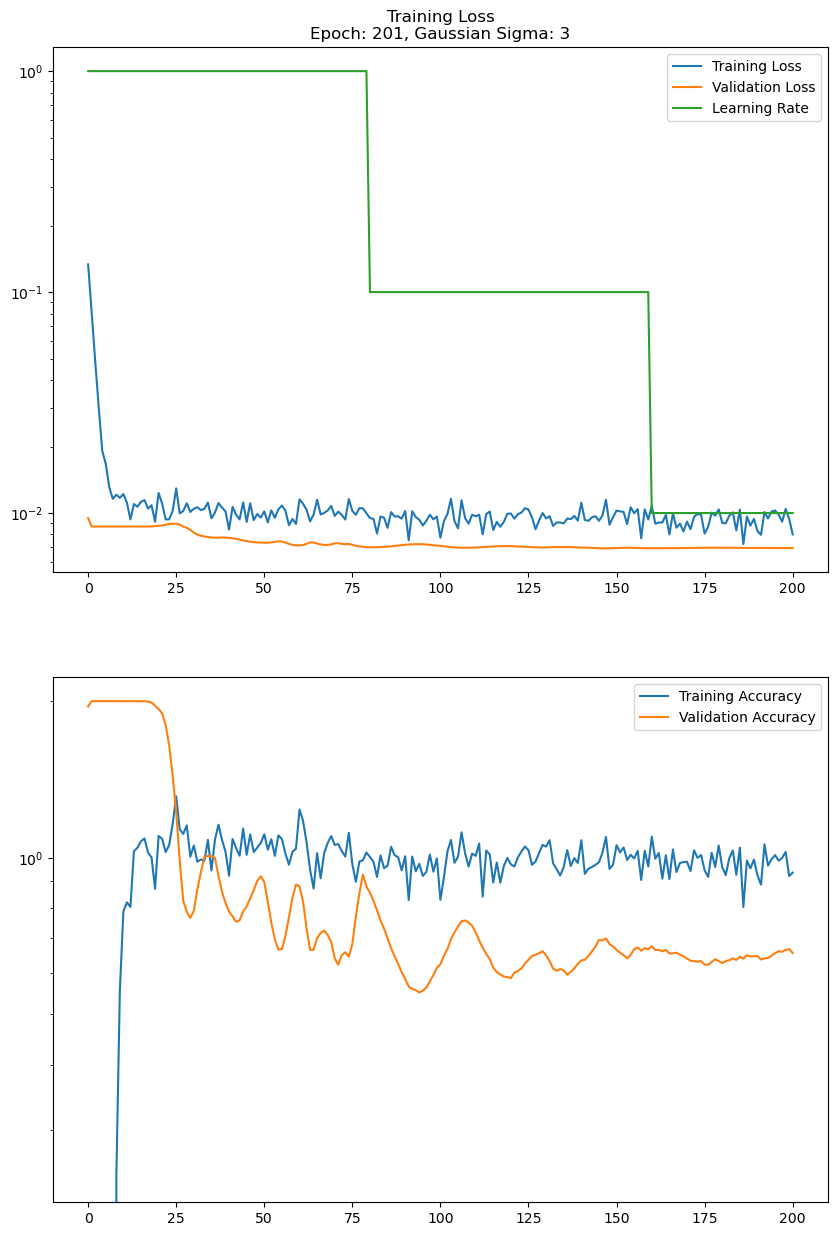

/gpfs/space/home/eckhardt/sanger/results/cellnet/240531-184339-sigma-val-all-RUNNING/util/plot.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


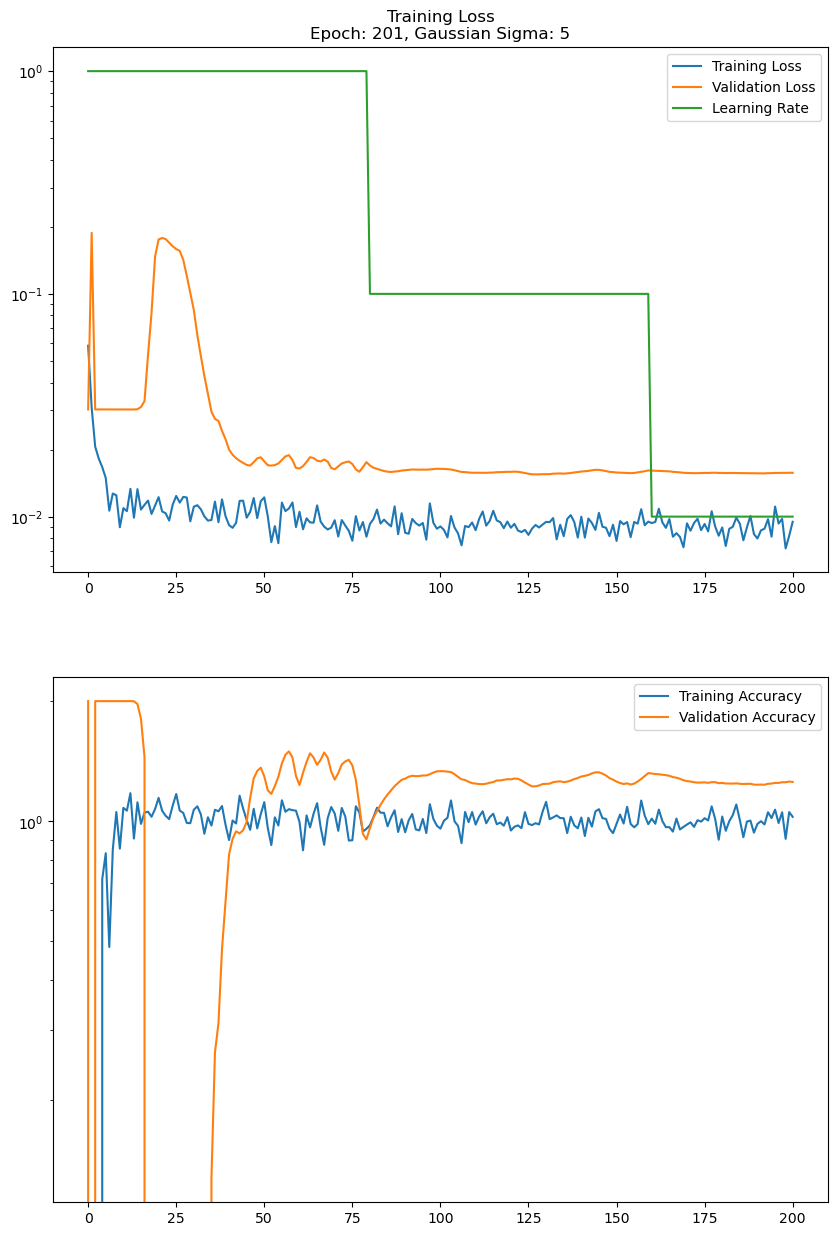

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


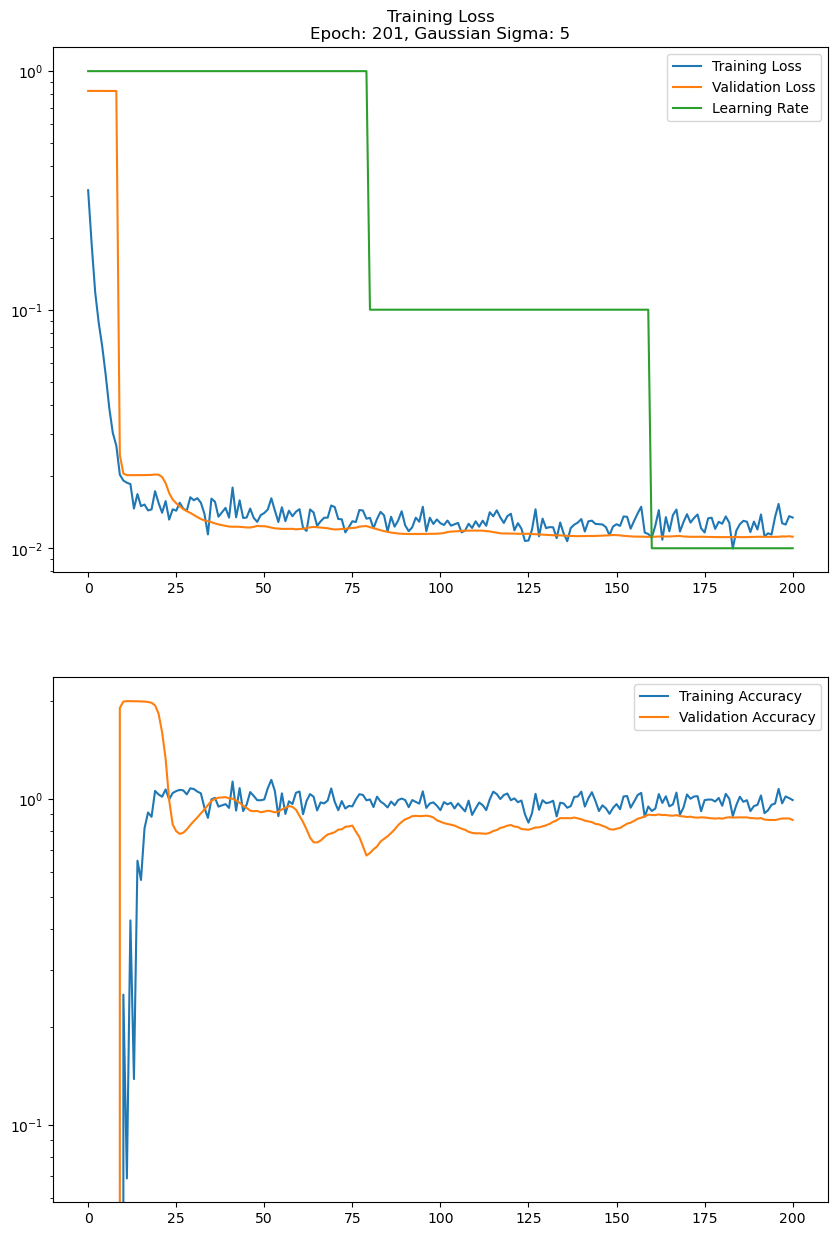

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


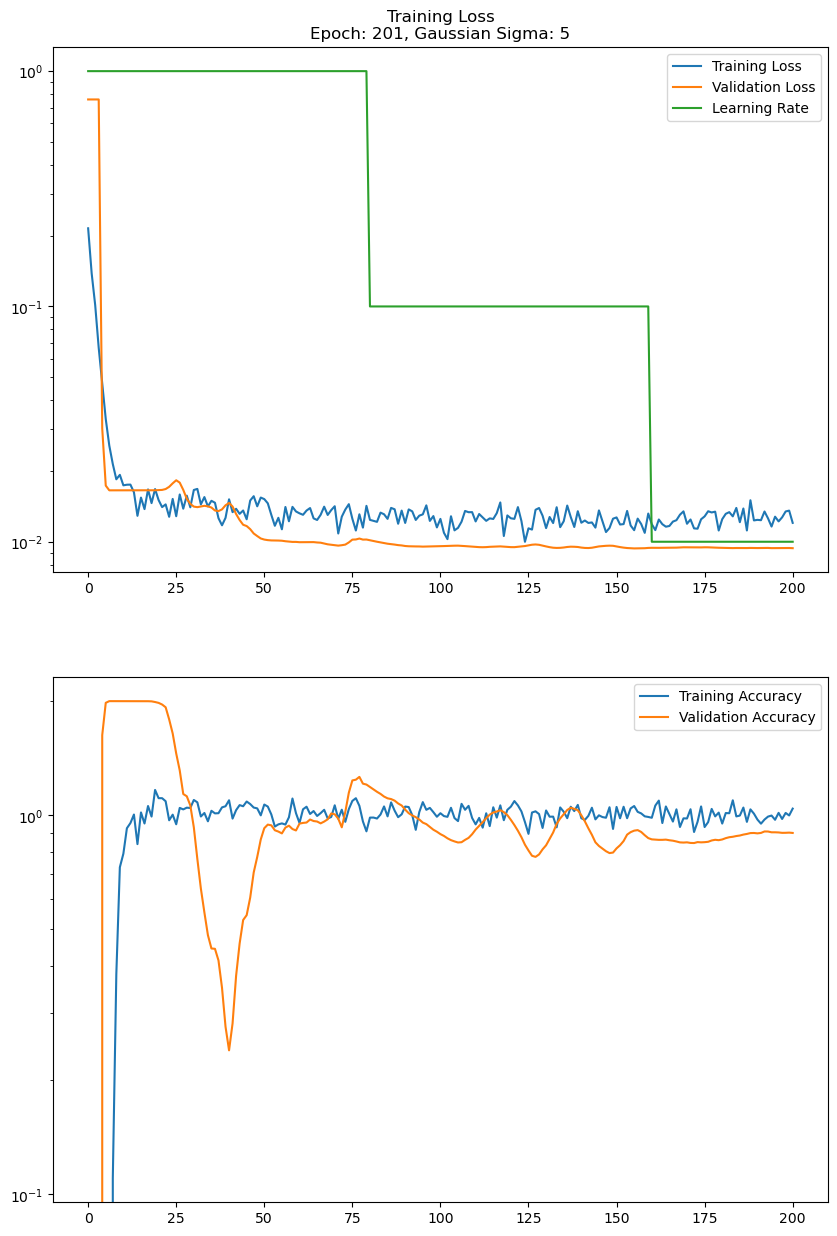

/gpfs/space/home/eckhardt/sanger/results/cellnet/240531-184339-sigma-val-all-RUNNING/util/plot.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


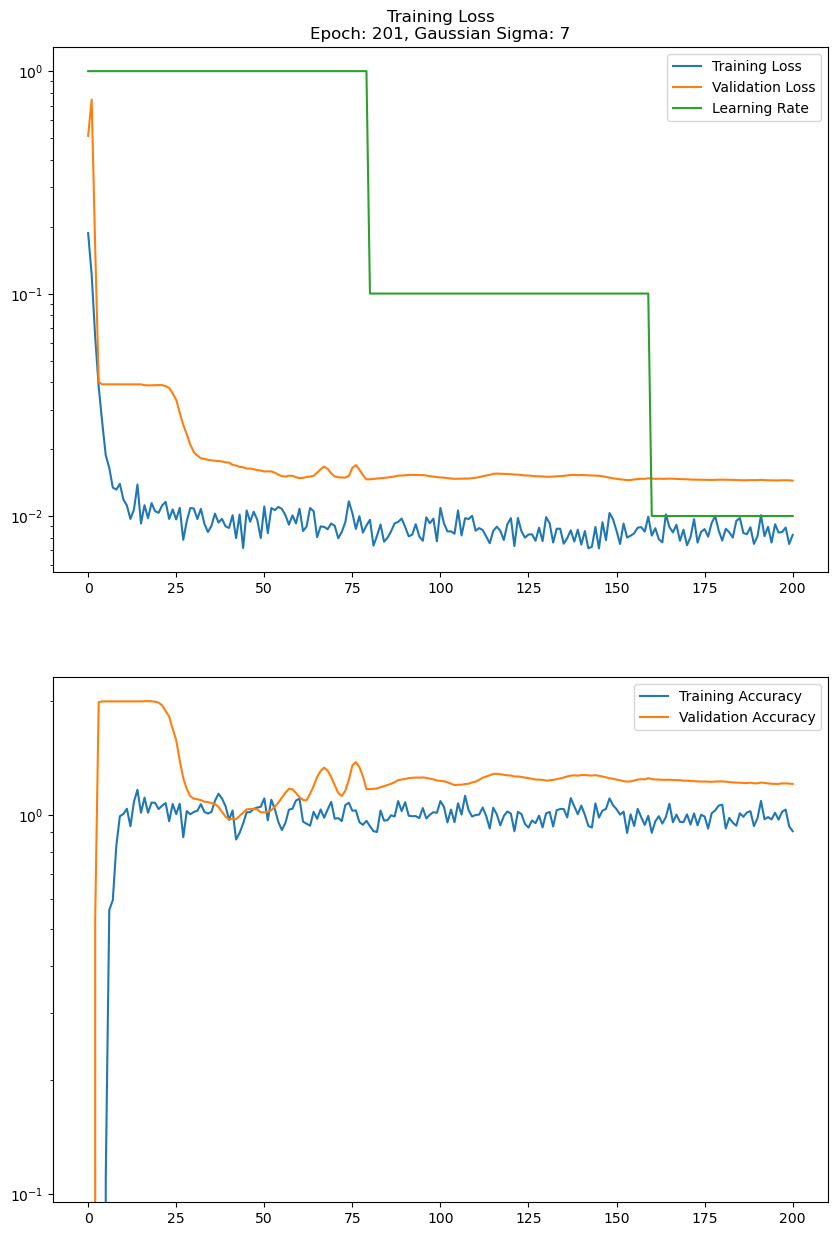

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


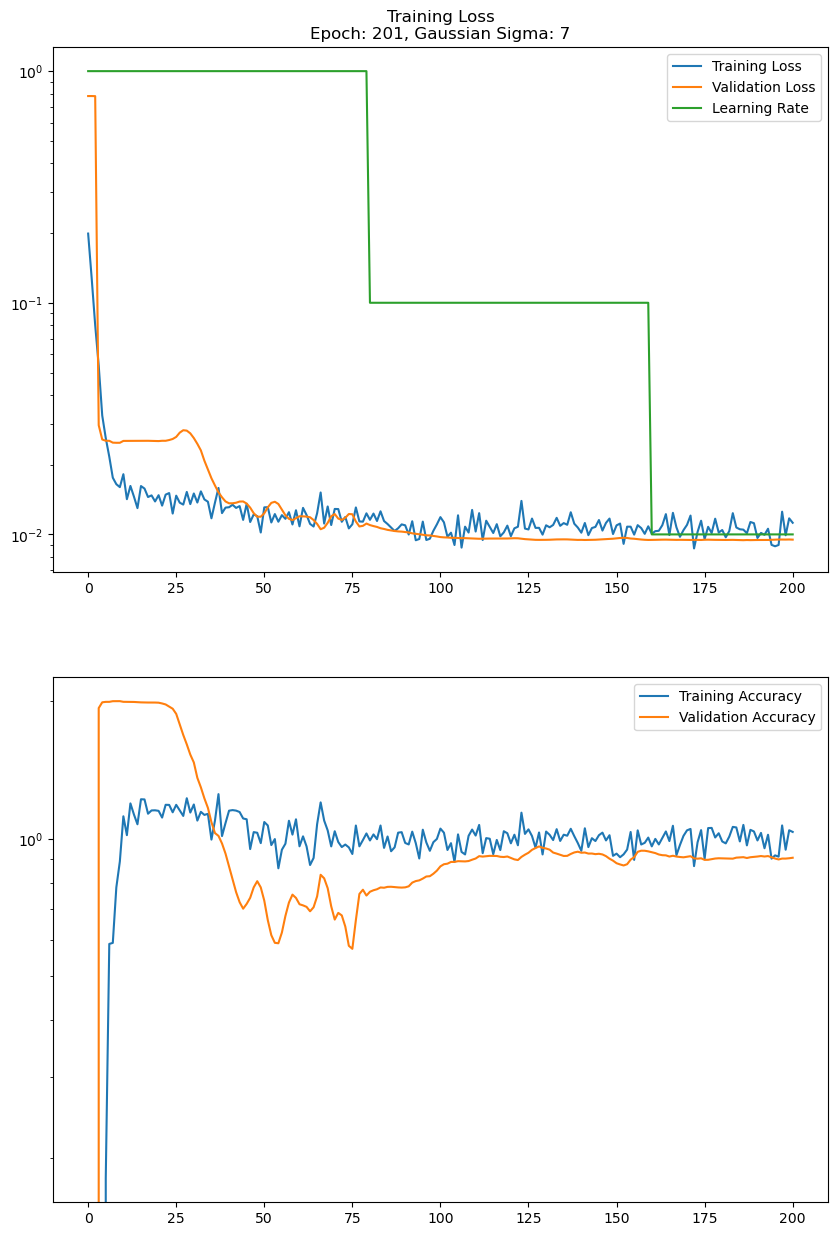

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


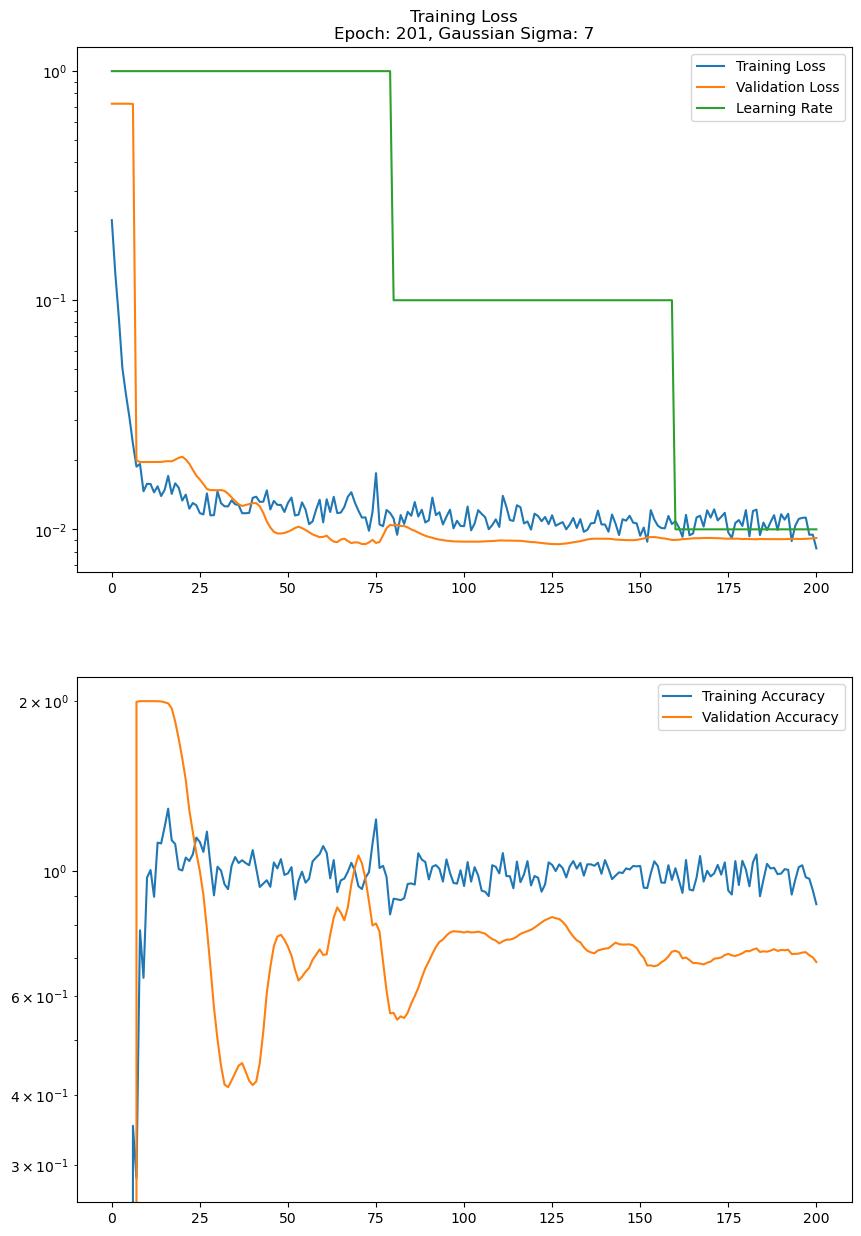

/gpfs/space/home/eckhardt/sanger/results/cellnet/240531-184339-sigma-val-all-RUNNING/util/plot.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


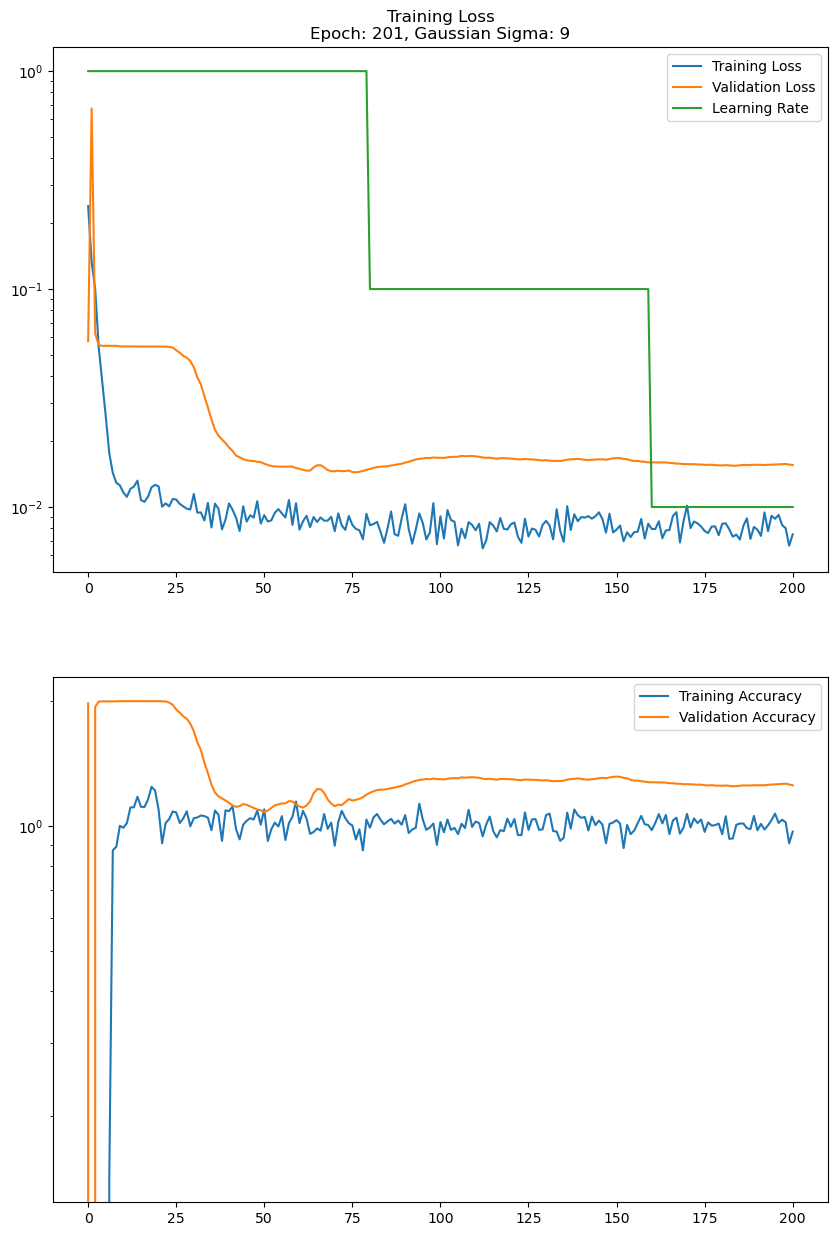

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


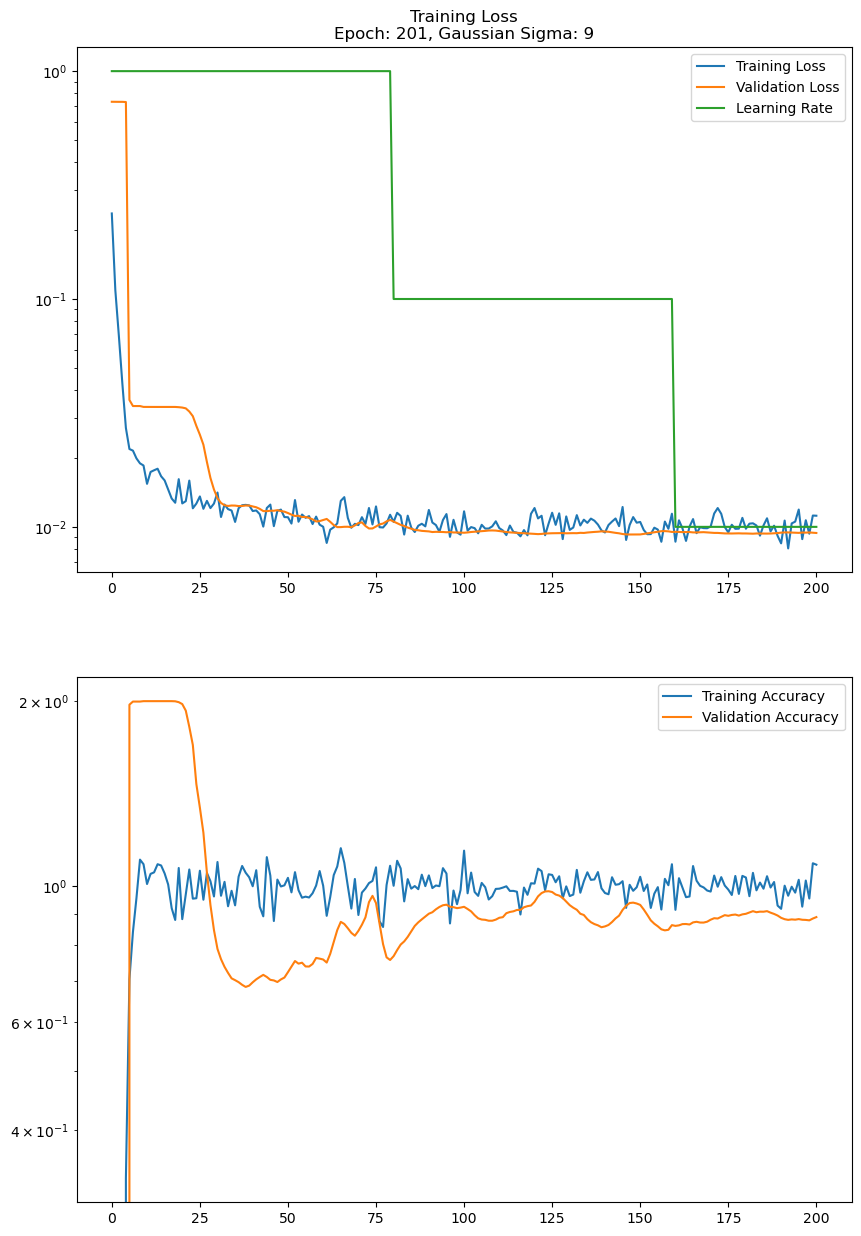

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


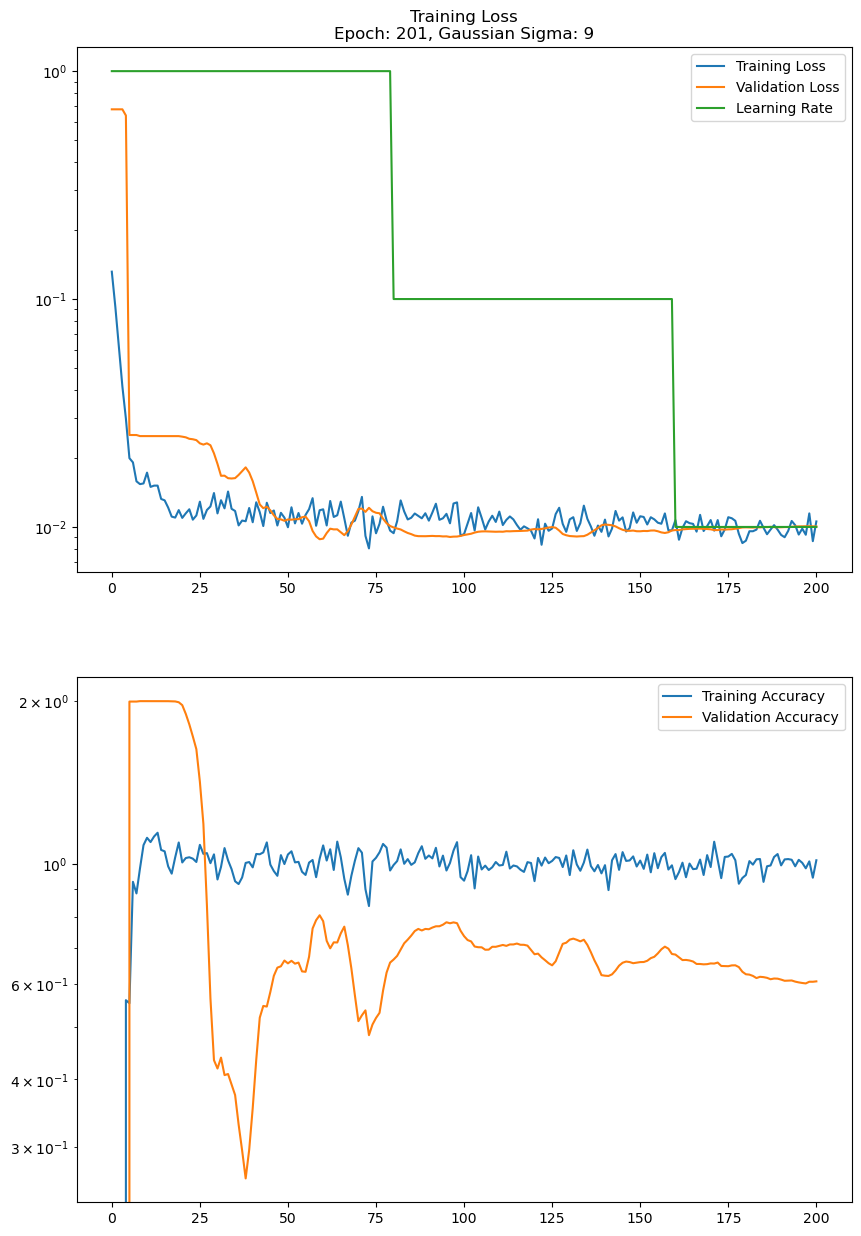

/gpfs/space/home/eckhardt/sanger/results/cellnet/240531-184339-sigma-val-all-RUNNING/util/plot.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


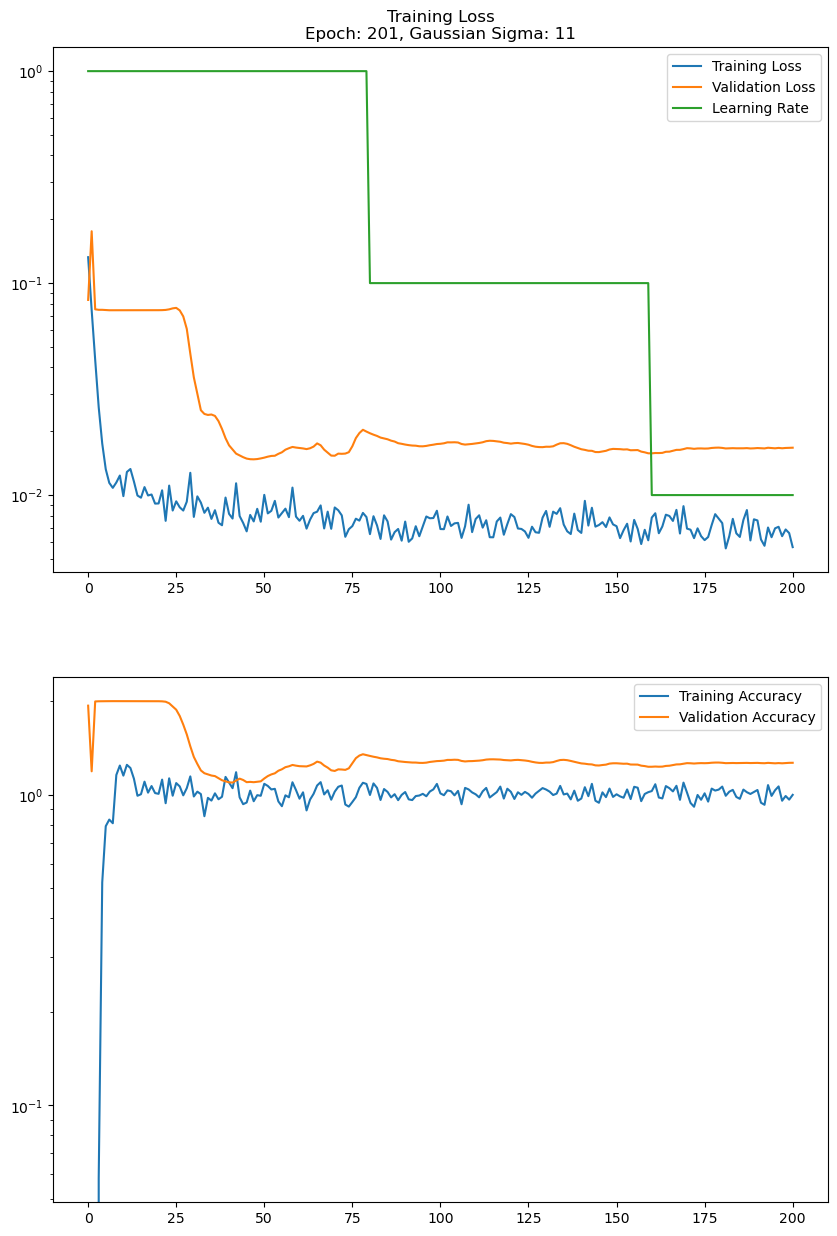

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


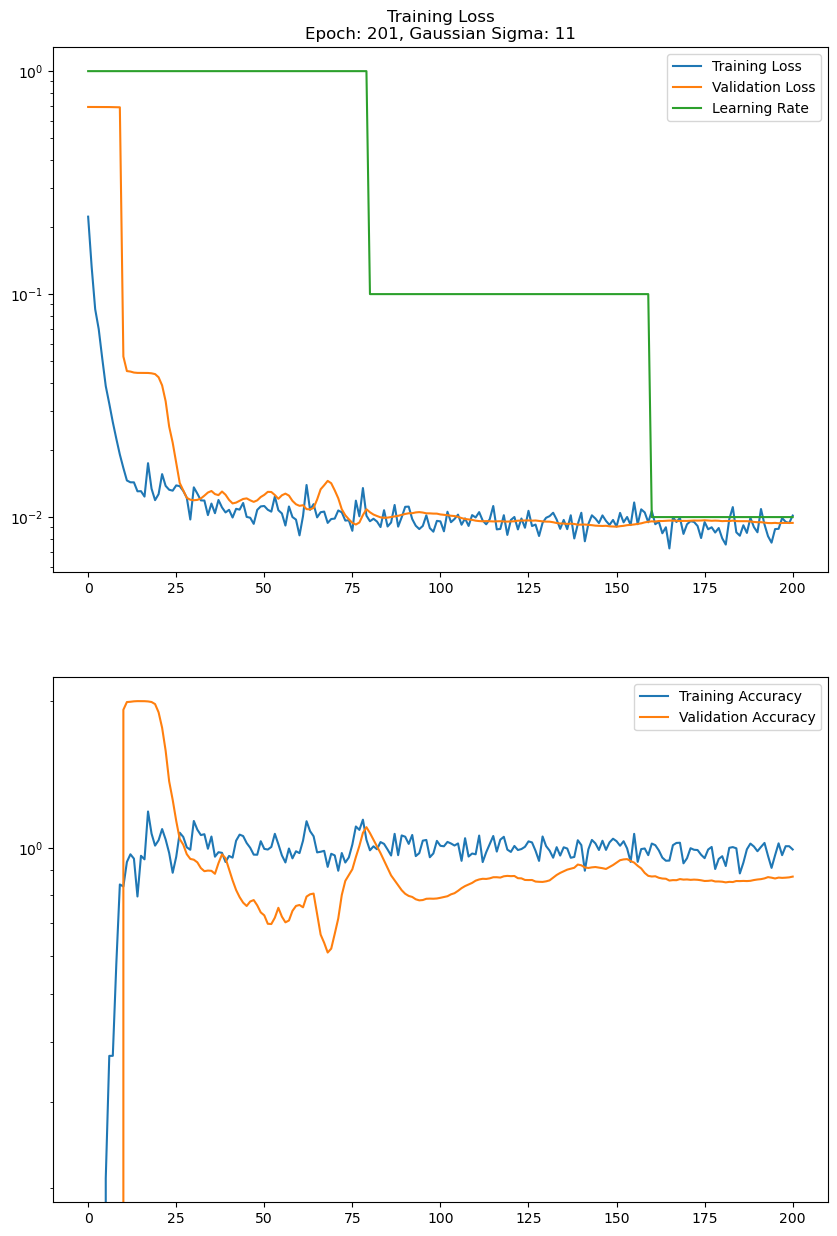

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


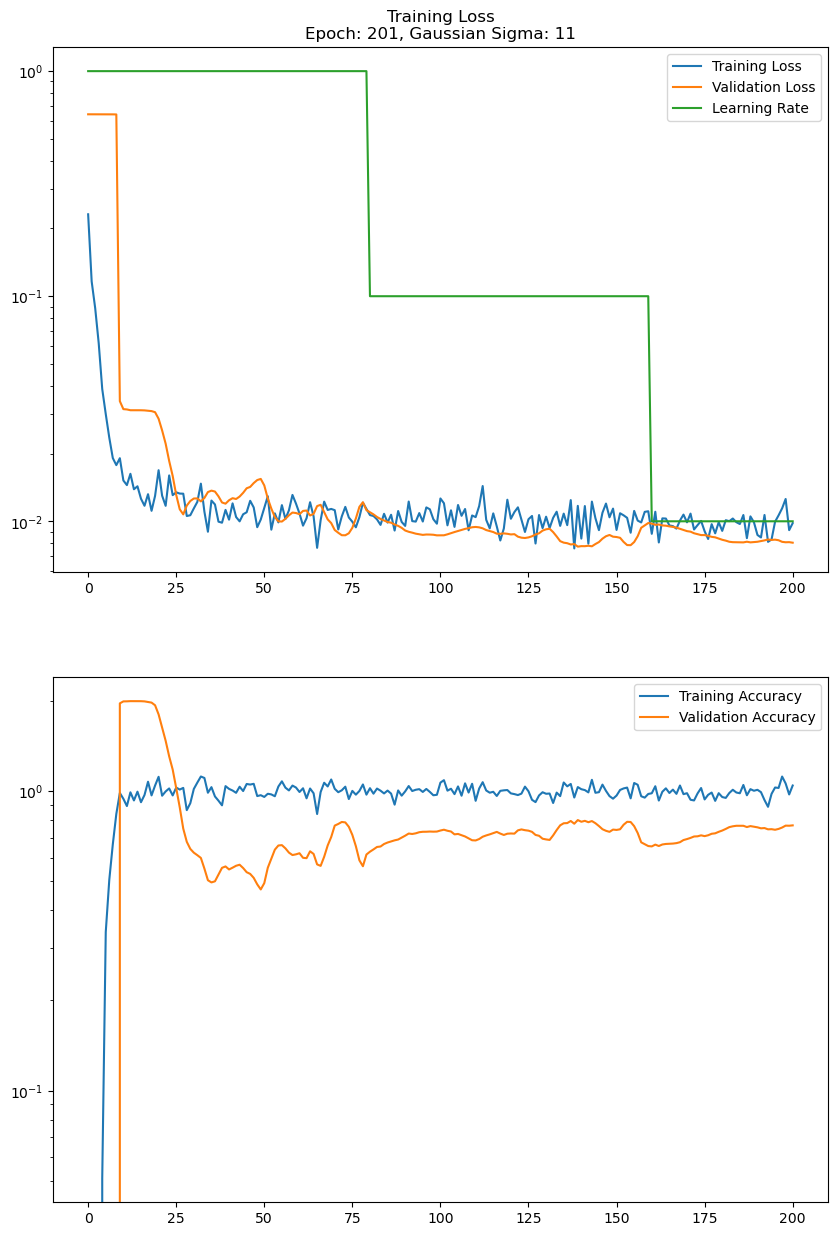

/gpfs/space/home/eckhardt/sanger/results/cellnet/240531-184339-sigma-val-all-RUNNING/util/plot.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


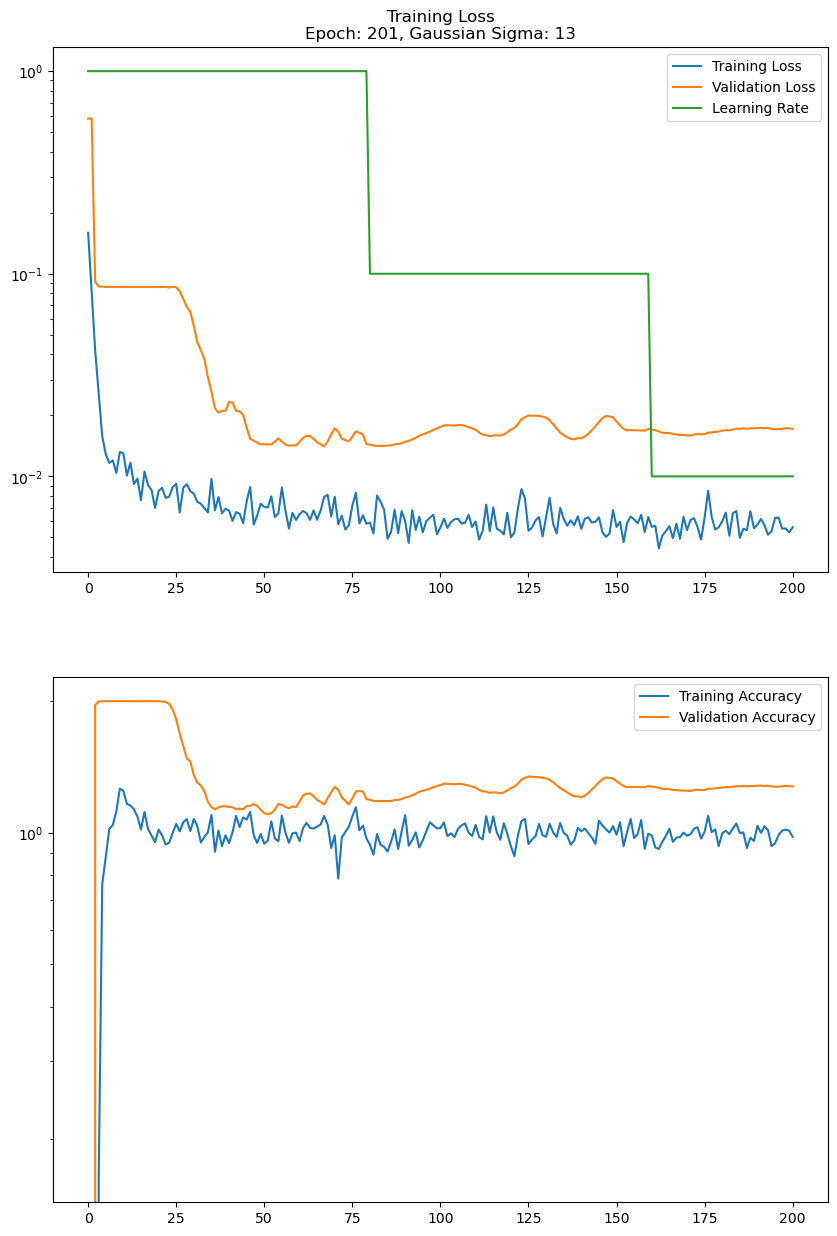

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


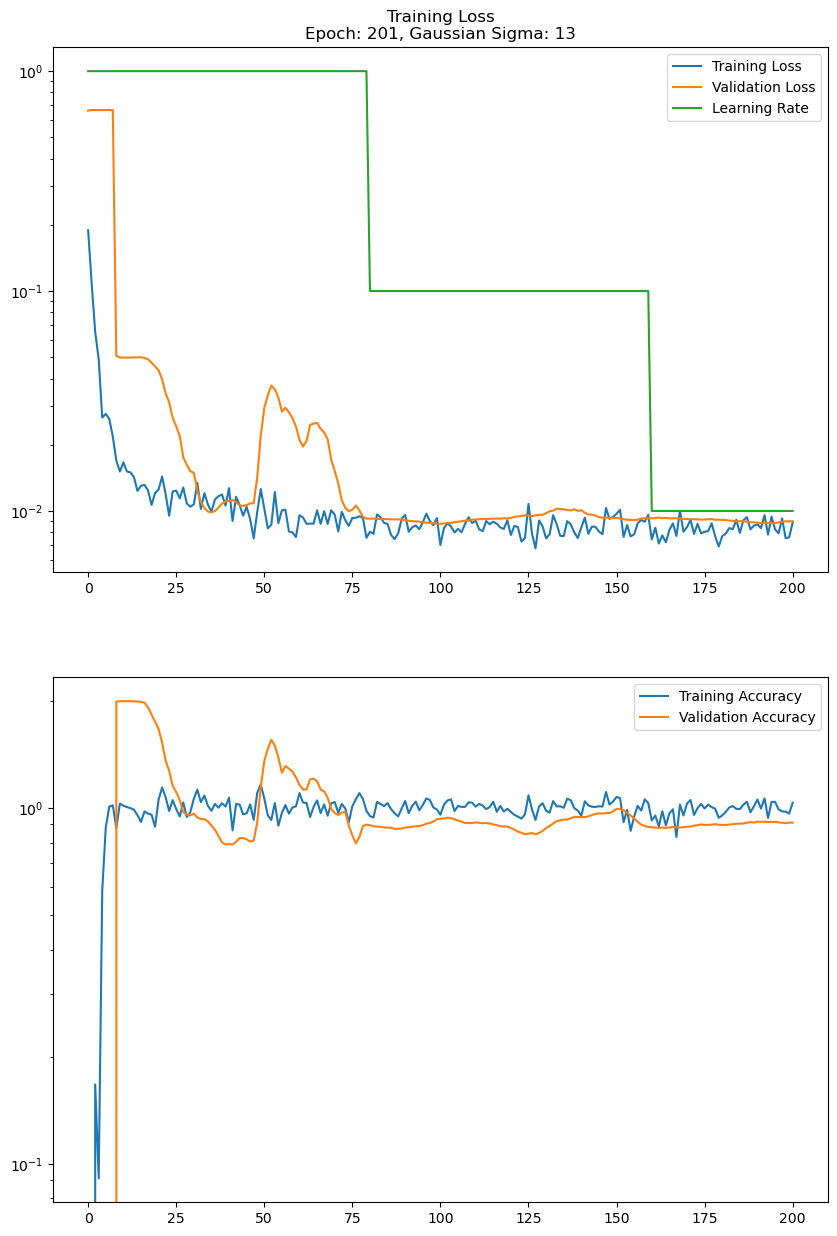

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


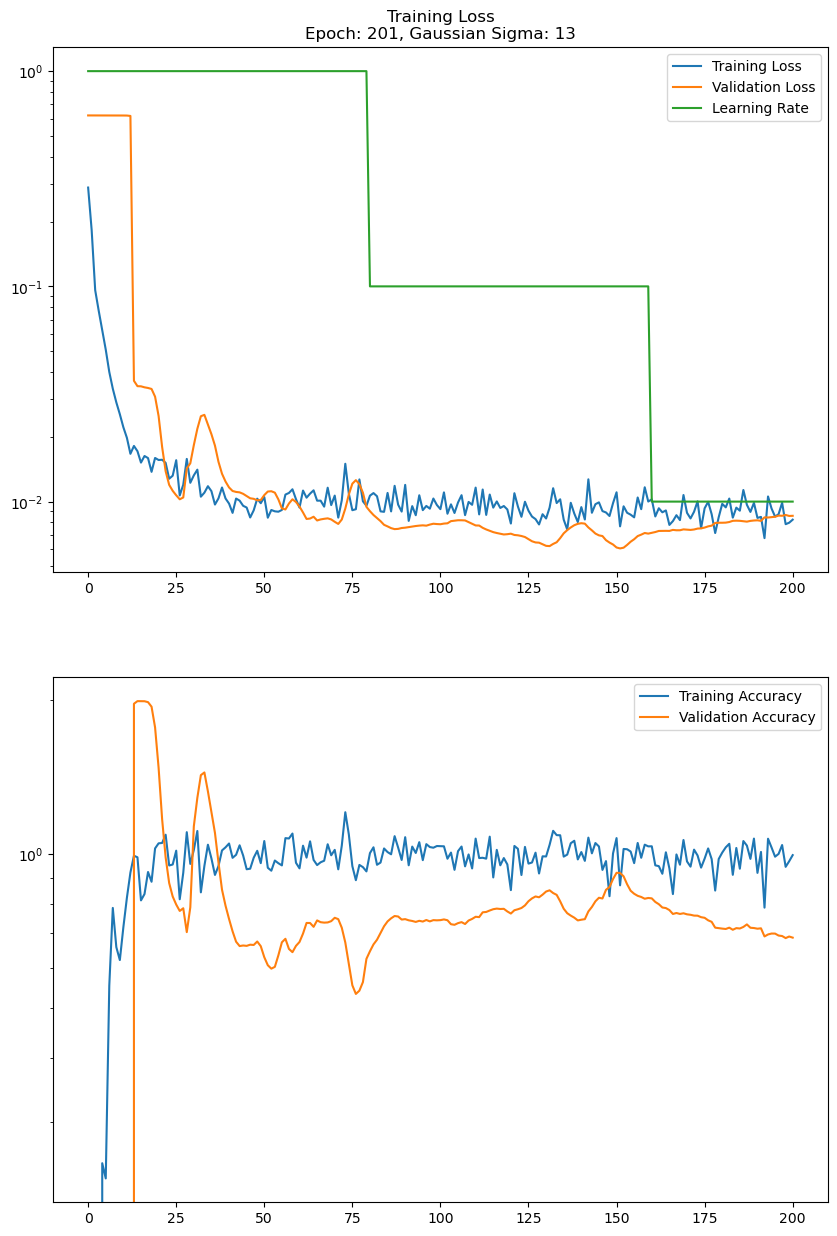

/gpfs/space/home/eckhardt/sanger/results/cellnet/240531-184339-sigma-val-all-RUNNING/util/plot.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


In [5]:

#def count(y): return yunnorm(y).sum().item()

def accuracy(y,z): 
  ny, nz = y.sum().item(), z.sum().item()
  return 1 - (ny - nz) / nz

def train(epochs, model, optim, lossf, sched, kp2hm, traindl, valdl=None, info={}):
  log = pd.DataFrame(columns='tl vl ta va lr'.split(' '), index=range(epochs))
  def epoch(dl, train):
    l = 0; a = 0; b = 0
    for b, B in enumerate(dl):
      x,m = B['image'].to(device), B['masks'][0].to(device)
      z = kp2hm(B).to(device)

      y = model(x)
      loss = lossf(y*m, z*m) 
      l += loss.item()
      a += accuracy(y*m, z*m) # type: ignore

      if train:
        loss.backward()
        optim.step()
        optim.zero_grad()

    return l/(b+1), a/(b+1)

  for e in range(epochs):
    L = log.loc[e]
    L['lr'] = optim.param_groups[0]['lr']
  
    model.train()
    L['tl'], L['ta'] = epoch(traindl, train=True)
    sched.step() 
  
    if valdl is not None: 
      model.eval()
      with torch.no_grad():
        L['vl'], L['va'] = epoch(valdl, train=False) 

    if DRAFT: plot.train_graph(e, log, info=info, key2text=key2text, clear=True)
  plot.train_graph(epochs, log, info=info, key2text=key2text) 
  return log


splits = [([1], [2])] if DRAFT else dict(
  one = [([1], [2,4])],
  all = [([2,4], [1]), ([1,4], [2]), ([1,2], [4])],
)[IMAGES]

results = pd.DataFrame()
if not DRAFT: [os.makedirs(p, exist_ok=True) for p in ('preds', 'plots')]
for p in [1] if DRAFT else ps:
  for ti, vi in splits:
    cfg = obj(**(dict(
      sigma=3.5, 
      maxdist=26, 
      fraction=1, 
      sparsity=1)
      | {P: p}))
    loader = lambda ids, mode: data.mk_loader(ids, bs=1 if mode=='test' else 16, transforms=mkAugs(mode), shuffle=False, cfg=cfg)
    traindl, valdl = loader(ti, AUGS), loader(vi, 'val' if AUGS=='train' else 'test')
    
    kp2hm, yunnorm = data.mk_kp2mh_yunnorm([1,2,4], cfg)

    model = mk_model()
    optim = torch.optim.Adam(model.parameters(), lr=5e-3)
    lossf = torch.nn.MSELoss()
    sched = torch.optim.lr_scheduler.StepLR(optim, step_size=80, gamma=0.1)

    log = train((5 if CUDA else 1) if DRAFT else 201, model, optim, lossf, sched, kp2hm, traindl, valdl, info={P: p})

    _row =  pd.DataFrame(dict(**{P: [p]}, ti=[ti], vi=[vi], **log.iloc[-1]))
    results = _row if results.empty else pd.concat([results, _row], ignore_index=True)

    # save predictions to disk
    for ii, t in [(ti, 'T'), (vi, 'V')]:
      for i in ii:
        B = next(iter(data.mk_loader([i], bs=1, transforms=mkAugs('test'), shuffle=False, cfg=cfg)))

        model.eval()
        with torch.no_grad(): y = cpu(model(B['image'].to(device)))

        B = batch2cpu(B, z=kp2hm(B), y=y)[0]

        id = f"{P}={p}-{t}{i}"
        ax1 = plot_overlay(B, cfg) 
        ax2 = plot_diff   (B, cfg)

        if vi==[4] and not DRAFT: 
          #np.save(f'preds/{id}.npy', y)
          plot.save(ax1, f'plots/{id}.pred.png')
          plot.save(ax2, f'plots/{id}.diff.png')
        if not DRAFT:
          plt.close('all')

,sigma,ti,vi,tl,vl,ta,va,lr
0,1,"[2, 4]",[1],0.000914,0.001724,-1.094439,0.190461,0.01
1,1,"[1, 4]",[2],0.001304,0.001184,-0.607892,-0.737604,0.01
2,1,"[1, 2]",[4],0.001435,0.000974,-0.323377,-1.032109,0.01
3,3,"[2, 4]",[1],0.006470,0.011691,0.932428,1.218234,0.01
4,3,"[1, 4]",[2],0.009497,0.008282,1.044211,0.905281,0.01
5,3,"[1, 2]",[4],0.008000,0.006940,0.936072,0.655401,0.01
6,5,"[2, 4]",[1],0.009484,0.015732,1.026106,1.254790,0.01
7,5,"[1, 4]",[2],0.013450,0.011175,0.994084,0.863783,0.01
8,5,"[1, 2]",[4],0.012028,0.009390,1.041150,0.898175,0.01
9,7,"[2, 4]",[1],0.008218,0.014414,0.906381,1.207359,0.01


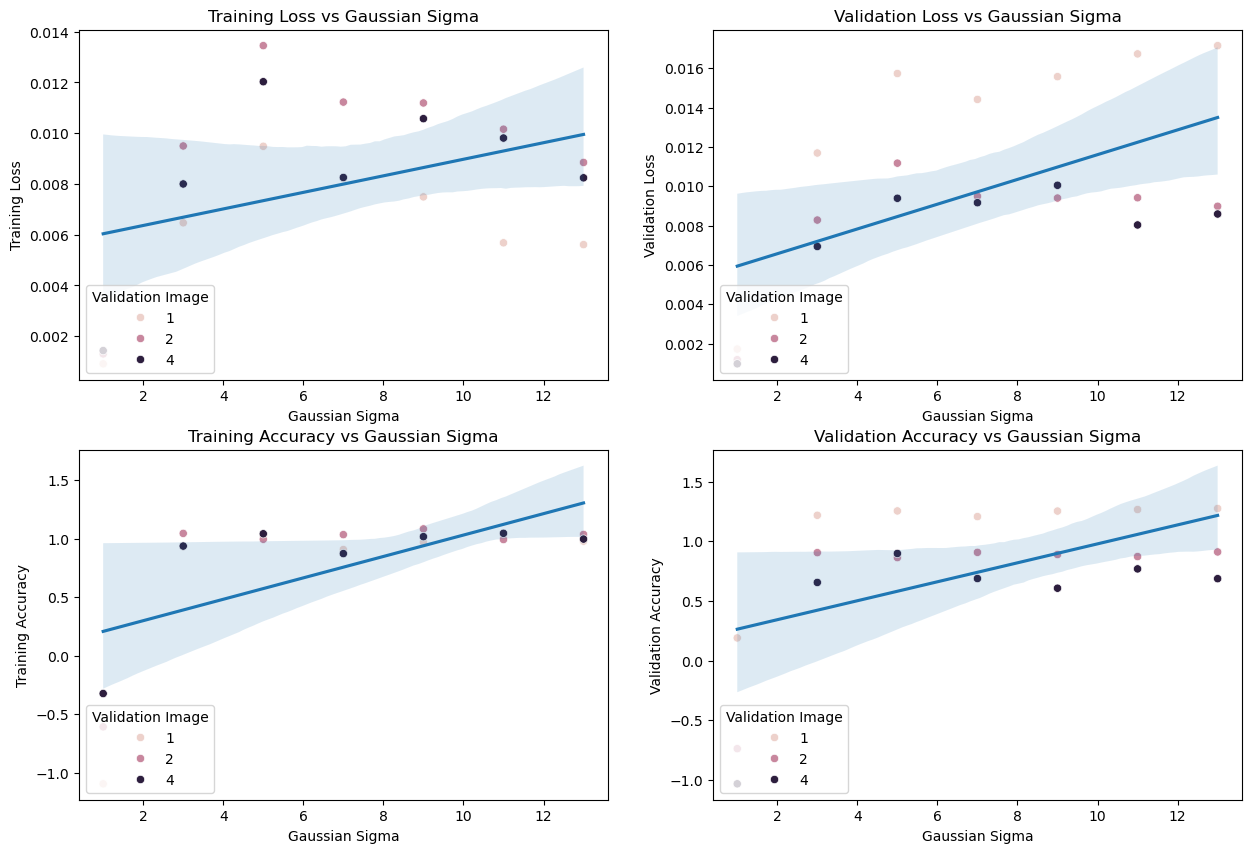

In [6]:

if not DRAFT:
  results.to_csv('results.csv', index=False, sep=';')
  R = pd.read_csv('results.csv', sep=';', converters=dict(ti=ast.literal_eval, vi=ast.literal_eval)).rename(columns=dict(vi=key2text['vi']))
  plot.regplot(R, P, key2text)

results